# Logistic Regression on the lab data
We will test in this notebook the efficiency of a logistic regression to classify the different species based on the 3x1m fluorometer.

## Part 1 : The data

Let's open and visualize the data

In [6]:
import pandas as pd 

data = pd.read_csv("/home/flavien/Documents/these/mf/Boussole/Data/labo/results_reshape.csv")

#remove the points where we have no HPLC dat (i.e. the chla_qa is NA)

data_with_hplc = data[data['chla_qa'].notna()]

print(
    f"The original data has "
    f"{len(data)} samples"
    f" and the data with HPLC has "
    f"{len(data_with_hplc)} samples")

The original data has 190 samples and the data with HPLC has 66 samples


In [7]:
#filter data with less than 0.1 chla

data_conc = data[data['chla_conc_spectro'] > 0.2]

#select the cols we want
data_sel = data_conc[["440nm_mean", "470nm_mean", "532nm_mean", "strain", "replicate"]]

#remove the NaN
data_sel = data_sel.dropna()

#rename columns to make it easier to work with
data_sel = data_sel.rename(columns = {"440nm_mean": "f440",
                                    "470nm_mean": "f470",
                                    "532nm_mean": "f532"})

#compute the ratio between each excitation channel
data_sel = data_sel.assign(f440_f470 = lambda x: x['f440']/x['f470'],
                f532_f470 = lambda x: x['f532']/x['f470'],
                f532_f440 = lambda x: x['f532']/x['f440'])




In [8]:
#add common names
def categorise(row):
    if row["strain"] in ["RCC1717", "RCC76", "RCC4213"]:
        return "Diatom"
    elif row["strain"] in ["RCC162", "RCC156", "PCC9511"]:
        return "Prochlorococcus"
    elif row["strain"] in ["RCC2379", "RCC2374", "RCC2319"]:
        return "Synechococcus"
    elif row["strain"] == "RCC100":
        return "Pelagophyte"
    elif row["strain"] == "RCC3006":
        return "Dino" 

data_sel["common_name"] = data_sel.apply(lambda row: categorise(row), axis = 1)

data_sel = data_sel[data_sel["common_name"] != "Dino"]

We now have a dataset with the different strain that are grouped under common taxa name. We will look at the distribution of the value of the ratio between the 3 excitation wavelength of the different taxa. We have the intuition thta we should be able to discriminate the different taxa based on those ratio.

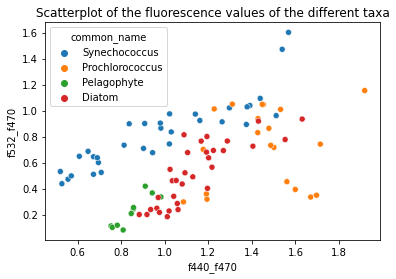

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data = data_sel, x = "f440_f470", y = "f532_f470", hue = "common_name")
plt.title("Scatterplot of the fluorescence values of the different taxa")
plt.show()

Looking at the plot, we see that the different taxa seems to have more or less homogenous value of fluorescence ratios. We should be able to build a classification model based on the ratios as descriptors.

## Part 2: Prediction using Support Vector Classifier

Let's try to implement a Support Vector Classifier. As we may not be able to linearly delimitate the samples we will use a RBf kernel. 

In [10]:
#Select relevant columns

data_sel_minimal = data_sel[["f440_f470", "f532_f470"]]
target = data_sel["common_name"]


In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

#Create our SVC model
svc_model = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma=5, C = 1))

To test SVC model generalization quality we will use a cross validation method. <br/>
As the fluorescence data were acquirred doing 3 biological replicates, we will train subsequently our model on 2 replicates and test the prediction on the third one.<br/>
The accuracy is corrected for the difference of taxa samples size. (e.g. there is more Syn data than Pelagophytes data)

In [12]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import LeaveOneGroupOut

#create a group index
group, _ = pd.factorize(data_sel["replicate"])
cv = LeaveOneGroupOut()
cv_scores = cross_validate(svc_model, data_sel_minimal, target, cv=cv,
                             n_jobs=2, scoring = "balanced_accuracy", groups = group,
                             return_estimator=True)

result = cv_scores["test_score"].mean() * 100
print(
    f"The mean accuracy of the SVC is"
    f" {result.round(2)}% of good prediction")


The mean accuracy of the SVC is 74.65% of good prediction


In a next step we want to look at the confusion matrix. This will provides information on the precision and recall of the classification model.

In [14]:
#use cross_val_predict to get the predictions of the cross_validation
from sklearn.model_selection import cross_val_predict

cv_predicted = cross_val_predict(svc_model, data_sel_minimal, target, cv=cv,
                             n_jobs=2, groups = group)


In [15]:
#Build the confusion matrix
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(target, cv_predicted)
type(conf_mat)

numpy.ndarray

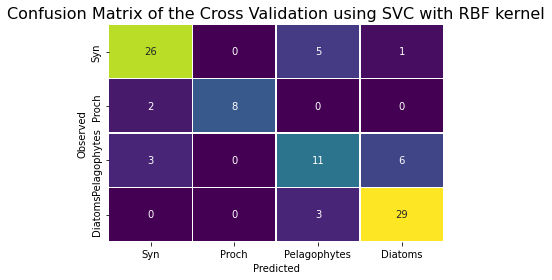

In [16]:
#Plot the confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.heatmap(conf_mat, linewidths = 0.5, cmap = "viridis", annot = conf_mat, cbar = False)
ax.set_xticks([0.5, 1.5, 2.5, 3.5])
ax.set_yticks([0.5, 1.5, 2.5, 3.5])
ax.set_xticklabels(['Syn','Proch','Pelagophytes','Diatoms'])
ax.set_yticklabels(['Syn','Proch','Pelagophytes','Diatoms'])
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title('Confusion Matrix of the Cross Validation using SVC with RBF kernel', fontdict={'fontsize': 16, 'fontweight': 'medium'})
plt.show()


We can observe that Diatoms Proch and Syn got a pretty good precision, and the model perform a slight less on the Pelagophytes.
<br/>
The next plot gives information on how the model decide to which taxa belong a sample.

In [17]:
import numpy as np
data_np = data_sel_minimal.to_numpy()

target_np, _ = pd.factorize(target)

target_np = target_np.astype(np.int_)

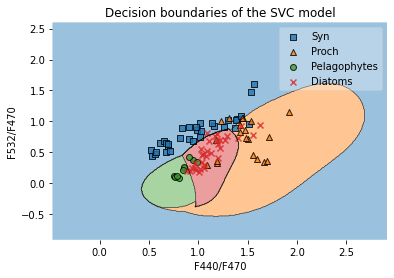

In [21]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

svm = SVC(C=1, kernel='rbf')
svm.fit(data_np, target_np)

ax = plot_decision_regions(data_np, target_np, clf=svm, legend=2)

# Adding axes annotations
plt.xlabel('F440/F470')
plt.ylabel('F532/F470')
plt.title('Decision boundaries of the SVC model')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          ['Syn', "Proch", "Pelagophytes", "Diatoms"], 
           framealpha=0.3, scatterpoints=1)

plt.show()

In conclusion, the fluorometer 3X1M is capable of discrimination between different phytoplankton taxa. <br/>
The signal being dependant of the different taxa, we may be able to use is in-situ to get information on the phytoplankton community composition.